In [1]:
import matplotlib

In [2]:
matplotlib.use('Agg')

In [3]:
%matplotlib inline

In [4]:
import collections

In [5]:
import csv

In [6]:
import itertools

In [7]:
import numpy as np

In [8]:
import os

In [9]:
import pandas as pd

In [10]:
import scipy.special

In [11]:
import scipy.stats as stats

In [12]:
from statsmodels.sandbox.stats.multicomp import fdrcorrection0

In [13]:
from sklearn import metrics

---

In [14]:
os.chdir('/work/jyoung/genetic_interact/src')

In [11]:
import pyuserfcn

In [13]:
import func_net_pred

In [15]:
import clust_intact

In [16]:
import intactadjmat

---

**2015 September 9**

Start with *Saccharomyces cerevisiae*. For predictive seed sets (0.8 &le; AUC < 1.0), examine all possible pairs and count the number of genetic interactions between them. Execute for each type of genetic interaction. Seed sets are from BIOGRID v3.4.127 with all interactions before 2007 removed. 

**2015 September 10, 14**

It is not feasible to only examine all of the counts. There are 240 seed gene sets with 0.8 &le; AUC < 1.0, which yields 28680 total pairs - far too many to examine one-by-one. Try using a binomial distribution to calculate the significance of interaction between seed sets. Suppose the number of genes in the 1<sup>st</sup> seed set is *n*<sub>1</sub>, the number of genes in the 2<sup>nd</sup> seed set is *n*<sub>2</sub>, and the number of interactions between the sets is *k*. The question is what to use for the probability *p* of a "success." Should it be 1 divided by the total number of all interacting pairs? The overall total number of pairs that were tested is not known, so it is not possible to calculate the number of interacting pairs divided by the number tested. Could the number of genes in the interaction set choose 2 be used instead? 

In [69]:
experimentSys = 'Dosage Growth Defect'

In [18]:
node2edgewt = clust_intact.process_func_net('yeastnet2.gene.txt')
gene2idx = clust_intact.assign_gene_indices(node2edgewt)

In [19]:
matrixPath = '/work/jyoung/genetic_interact/data/YeastNet2_adj_matrix.npy'
adjMat = np.load(matrixPath)

In [13]:
len(gene2idx.keys())  # number of genes in functional net

5483

In [70]:
seedSets = clust_intact.read_biogrid(experimentSys, 'BIOGRID-3.4.127-for-yeastnetv2.txt')

Find number of BIOGRID interacting pairs:

In [18]:
biogridInteracts = set()
for seed in seedSets.keys():
    for interactor in seedSets[seed]:
        biogridInteracts.update([(seed, interactor), (interactor, seed)])

In [29]:
len(biogridInteracts)  # number of interacting pairs in BIOGRID

3712

In [71]:
seedAUC, seed2interactors = clust_intact.seed_set_predictability(gene2idx, adjMat, seedSets)

Now it is possible to find the number of interacting pairs where both genes are in network:

In [20]:
inNetwkInteracts = set()
for seed in seed2interactors.keys():
    for interactor in seed2interactors[seed]:
        inNetwkInteracts.update([(seed, interactor), (interactor, seed)])

In [21]:
len(inNetwkInteracts)

3130

Create a list containing predictive seed genes.

In [22]:
lowerAUC = 0.8
upperAUC = 1.0

In [72]:
predictiveSeeds = list()
for p in seedAUC:  # p=(AUC, gene)
    if p[0] >= lowerAUC and p[0] < upperAUC:
        predictiveSeeds.append(p[1])

In [23]:
len(predictiveSeeds)

240

How many interacting pairs are there for predictive seeds?

In [21]:
interactPairs = set()
for seed in predictiveSeeds:
    for interactor in seed2interactors[seed]:
        interactPairs.update([(seed, interactor), (interactor, seed)])

In [19]:
len(interactPairs)  # number of interacting pairs (for predictive seed)

1624

Compute statistics for each pair of interactor sets. Try a binomial distributed null model. 

**2015 September 14**

The question of what the probability *p* of a "success" should be is not clear. The total number of genes among all interacting pairs could be used, but this might be overly conservative. 

In [24]:
numGenes = len(set(itertools.chain.from_iterable(inNetwkInteracts)))
print('Number of genes in network among all interactions:', numGenes)
p = len(inNetwkInteracts)/scipy.special.binom(numGenes, 2)
results = list()
for seedPair in itertools.combinations(predictiveSeeds, 2):  # seedPair=(seed1, seed2)
    interactionCount = 0
    num1stSet = len(seed2interactors[seedPair[0]])
    num2ndSet = len(seed2interactors[seedPair[1]])
    for genePair in itertools.product(seed2interactors[seedPair[0]], seed2interactors[seedPair[1]]):
        if genePair in inNetwkInteracts:
            interactionCount += 1
    n = num1stSet * num2ndSet
    pval = stats.binom.pmf(interactionCount, n, p) + stats.binom.sf(interactionCount, n, p)
    results.append((num1stSet, num2ndSet, interactionCount, pval))

Number of genes in network among all interactions: 1001


In [25]:
len(results)

28680

Is there any statistical significance at some FDR level? Try using Benjamini-Hochberg to control FDR at 5%. 

In [26]:
pvals = [x[3] for x in results]

In [27]:
rejected, pvalsCor = fdrcorrection0(pvals)

In [28]:
np.sum(rejected)

3794

Create directory to store text files in CSV format containing results.

    cd /work/jyoung/genetic_interact/results
    mkdir YeastInteractClust

In [33]:
os.chdir('/work/jyoung/genetic_interact/results/YeastInteractClust')

In [34]:
with open(''.join(experimentSys.split()) + 'Stats.txt', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['# genes in 1st set', '# genes in 2nd set', '# interactions btw sets', 'p-value'])
    for t in results:
        csvwriter.writerow(t)

**2015 September 10-11, 13-14**

Put the code above into a script so that results can be easily output for a given species and genetic interaction type. 

**2015 September 21**

It is important to note that the seed sets need to be carefully combined. For example, one seed set could be {a, b, c} and another could be {a, b, c, d}. The seed sets will be combined based on their overlap measured by the Jaccard index. The algorithm for combining them will start by considering all possible pairs of sets. If the intersection of each pair is greater than or equal to the Jaccard index, then a new set is formed by the union of the pair. Otherwise, the two sets in the pair are retained. Any set that was involved in a union is removed (unless one was a subset of the other). Now we have a new collection of sets, and the process of comparing pairs of these sets is repeated. The algorithm ends when no further unions are made. 

A script named *combining_sets_test.py* was written to test this algorithm. 

**2015 September 26**

Modify *clust_intact.py* to utilize the approach in *combining_sets_test.py* to combine the sets of genetic interactors. 

**2015 September 30**

Finished 1<sup>st</sup> working draft of *clust_intact.py* and began gathering results. "Synthetic Lethality" is taking an extremely long time to run... Noticed on October 3 that it finished running, so runtime was ~72 hrs.

**2015 October 1-2**

Adding code to *clust_intact.py* to write out input file for network visualization. *clust_intact.py* for synthetic lethality is still running, so a copy of it (with the added code) named *clust_intact_2.py* was created. A first look at the network for dosage rescue was visualized. *clust_intact_2.py* is intended to be temporary and will be subsumed by *clust_intact.py* once/if it finishes running for synthetic lethality. 

**2015 October 5-6**

*clust_intact_2.py* was re-named (and overwrote) *clust_intact.py*, which now contains code to plot networks. Currently, the networks are being examined for correctness and are used to see if the code is doing what it is intended to. Efforts to visualize the network using D3.js are on-hold, as NetworkX is currently sufficient. 

**2015 October 7**

Consider the following network:

Number of genes in functional network: 5483 

Number of predictive seed genes: 170 

The minimum Jaccard index is 0.5 

Number of set pairs: 8778 

Number of significant interacting pairs (5% FDR): 98 


The genes in the 1st cluster are:
frozenset({'RPL37A', 'UTP9', 'RPL6A', 'RPL35A', 'RPL17A', 'RPS1B', 'RPL41A', 'LSG1', 'SSF2', 'RPL11A', 'RPL43A', 'RPS26A', 'NOC3', 'RPL16B', 'RPS8A', 'PPS1', 'RPL42A', 'ARC1', 'RPS6A', 'RLP7', 'YVH1'})

The genes in the 2nd cluster are:
frozenset({'TCP1', 'CCT6', 'RPL12B', 'CCT2', 'CCT4', 'MRT4', 'CCT3'})


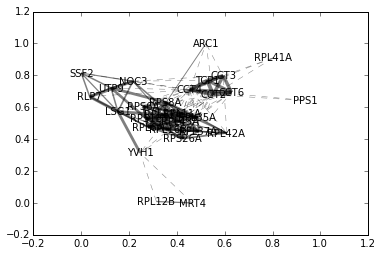

In [6]:
%run clust_intact 'Dosage Rescue' 'yeast'

Here, the genetic interaction type is dosage rescue for *S. cerevisiae*. The lower limit of predictability for seed gene sets is set to AUC = 0.9. The network shown has the most significant number of genetic interactions between two gene sets. Each gene set was formed from combining seed sets based on the Jaccard index. 

Clearly, the genes RPL41A and PPS1 have no functional partners. At first glance, this might indicate a coding error, but it turns out that there is no error. For a seed set to be predictive, not all of its members need to have high LLS sums although most of them should. RPL41A and PPS1 have LLS sums of 0.0 (their interactor is CCT4) and the rest of the genes in the set have relatively high ranks and LLS sums. The relevant code snippet for checking this is:

    argSortedSums = np.argsort(llsSum)[::-1]
    for g in seedSets[seedGene]:
        rank = np.where(argSortedSums == gene2idx[g])[0][0]
        score = llsSum[gene2idx[g]]
        print('The rank of', g, 'is', rank, 'with LLS sum', score)

**2015 October 8**

The task now is to run *clust_intact.py* on the remaining genetic interaction types and examine the networks, especially how they depend on parameters (e.g. AUC predictability limit, Jaccard index). It looks like dosage growth defect is going to take quite some time to run. Add code to *clust_intact.py* to save the combined sets, and profile the code. Created *dumpprof.py* in */work/jyoung/*. The job for dosage growth defect exhausted system memory and crashed. 

**2015 October 9**

The problem of how to appropriately combine sets was considered [here](http://cstheory.stackexchange.com/questions/17338/fast-algorithm-for-successively-merging-k-overlapping-sets).

Profiling tools such as *cProfile*, *line_profiler* from *kernprof*, and *memory_profiler* were used in attempts to identify the performance bottleneck. Dosage rescue was used as a test case. The output from *memory_profiler* was not informative as it was not obvious where the runaway memory usage was occurring. Both *cProfile* and *line_profiler* indicated that most of the time was spent calculating the binomial p-value. However, this turned out not to be the cause of the problem. By running *clust_intact.py* on dosage growth defect while monitoring system resources with *htop*, and then killing the job at various values of percent memory usage, it was found that increasing memory usage always occurred in the *combining_sets()* function (as initially suspected). Attempts at freeing memory by setting variables to *None* and using Python's *gc* garbage collector module failed to rectify the issue. Finally, the Python debugger *pdb* was used to discover that immediately after the "do" portion of the "do-while" setup in the *combining_sets()* function, the number of new "combined" sets (*newSetOfSets*) had actually increased compared to the initial set of sets (*setOfSets*)! This was certainly not originally intended. This problem can be made clear by considering the following toy example:

In [2]:
setOfSets = {frozenset({1, 2, 3}), frozenset({1, 2, 10}), frozenset({1, 2, 11}), frozenset({1, 2, 13})}

newSetOfSets = set()
deleteLater = set()

for pair in itertools.combinations(setOfSets, 2):
    if len(pair[0] & pair[1])/float(len(pair[0] | pair[1])) >= 0.5:
        pairUnion = pair[0] | pair[1]
        if pairUnion == pair[0]:
            newSetOfSets.add(pairUnion)
            deleteLater.add(pair[1])
        elif pairUnion == pair[1]:
            newSetOfSets.add(pairUnion)
            deleteLater.add(pair[0])
        else:
            newSetOfSets.add(pairUnion)
            deleteLater.update((pair[0], pair[1]))
    else:
        newSetOfSets.update((pair[0], pair[1]))

newSetOfSets = {x for x in newSetOfSets if x not in deleteLater}

In [3]:
setOfSets

{frozenset({1, 2, 11}),
 frozenset({1, 2, 10}),
 frozenset({1, 2, 13}),
 frozenset({1, 2, 3})}

In [4]:
newSetOfSets

{frozenset({1, 2, 3, 11}),
 frozenset({1, 2, 10, 11}),
 frozenset({1, 2, 3, 10}),
 frozenset({1, 2, 10, 13}),
 frozenset({1, 2, 3, 13}),
 frozenset({1, 2, 11, 13})}

**2015 October 10**

Motivated by the example above, a simple change was made to the *combining_sets()* function by substituting "<" for "!=" in the *while* statement. Re-running the script, the number of combined set pairs change from before for some genetic interaction types:

Dosage Rescue: 21321 &rarr; 24976, 256 &rarr; 353 <br>
Synthetic Lethality: 43365 &rarr; 86736, 16483 &rarr; 39396 <br>
Positive Genetic: 11325 &rarr; 14878, 5547 &rarr; 6474 <br>
Synthetic Rescue: 37950 &rarr; 54946, 5649 &rarr; 13048 <br>

**2015 October 11**

With the change from "!=" to "<", the top scoring network for dosage rescue in yeast, along with the genes in the 2 clusters are:

Number of genes in functional network: 5483 

Number of predictive seed genes: 264 

The minimum Jaccard index is 0.5 

Number of set pairs: 24976 

Number of significant interacting pairs (5% FDR): 353 

Genes in 1st set:
frozenset({'RGD1', 'PSP1', 'RHO2', 'NAB6', 'HOF1', 'IQG1', 'BEM3', 'CDC24', 'ROM1', 'CHS2', 'MYO1', 'RGD2', 'CYK3', 'MSS4', 'LRE1', 'RGA1', 'TUS1', 'DMA2', 'RHO1'})
Genes in 2nd set:
frozenset({'RGD1', 'PAP1', 'MYO1', 'RGD2', 'CYK3', 'MSS4', 'PSP1', 'RHO2', 'LRE1', 'ROM2', 'NAB6', 'HOF1', 'RGA1', 'IQG1', 'TUS1', 'BEM3', 'CDC24', 'DMA2', 'RHO1', 'ROM1', 'CHS2'})



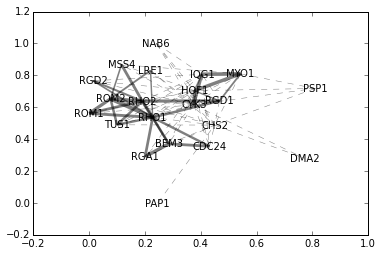

In [6]:
%run clust_intact 'Dosage Rescue' yeast

The 2<sup>nd</sup> set is a subset of the 1<sup>st</sup>, and this shouldn't happen. Adding code to remove sets that are subsets of other sets doesn't help much:

Number of genes in functional network: 5483 

Number of predictive seed genes: 264 

The minimum Jaccard index is 0.5 

Number of set pairs: 21528 

Number of significant interacting pairs (5% FDR): 272 

Genes in 1st set:
frozenset({'RGD1', 'PAP1', 'MYO1', 'RGD2', 'CYK3', 'MSS4', 'PSP1', 'RHO2', 'LRE1', 'ROM2', 'NAB6', 'HOF1', 'RGA1', 'IQG1', 'TUS1', 'BEM3', 'CDC24', 'DMA2', 'RHO1', 'ROM1', 'CHS2'})
Genes in 2nd set:
frozenset({'RGD1', 'MYO1', 'RGD2', 'CYK3', 'MSS4', 'PSP1', 'RHO2', 'BSP1', 'NAB6', 'RGA1', 'TUS1', 'BEM3', 'CDC24', 'ROM1', 'RHO1', 'CHS2'})



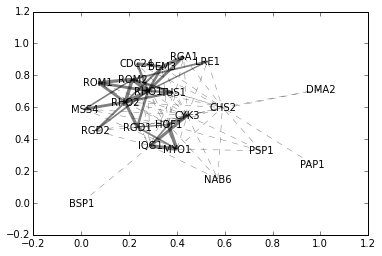

In [7]:
%run clust_intact 'Dosage Rescue' yeast

If the Jaccard index is set to 0.8, then there is still the problem of enough genes in common between the 2 sets to seemingly influence the significance of genetic interactions between them:

Number of genes in functional network: 5483 

Number of predictive seed genes: 264 

The minimum Jaccard index is 0.8 

Number of set pairs: 21528 

Number of significant interacting pairs (5% FDR): 294 

Genes in 1st set:
frozenset({'CHS2', 'MYO1', 'HOF1', 'IQG1', 'CYK3', 'SRO77', 'SRO7', 'MTL1'})
Genes in 2nd set:
frozenset({'RGD1', 'MYO1', 'RGD2', 'MSS4', 'PSP1', 'RHO2', 'LRE1', 'NAB6', 'HOF1', 'RGA1', 'IQG1', 'TUS1', 'BEM3', 'CDC24', 'DMA2', 'ROM1', 'RHO1', 'CHS2'})



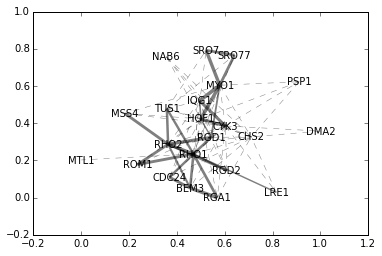

In [14]:
%run clust_intact 'Dosage Rescue' yeast

Above, genes in common are CHS2, HOF1, IQG1, and MYO1. Perhaps it would be better to remove genes in the intersection, as well as genes without functional partners, when calculating interaction significance. Result:

Number of genes in functional network: 5483 

Number of predictive seed genes: 264 

The minimum Jaccard index is 0.8 

Number of set pairs: 21528 

Number of significant interacting pairs (5% FDR): 190 

Genes in 1st set:
frozenset({'TCP1', 'CCT2', 'CCT4', 'CCT6'})
Genes in 2nd set:
frozenset({'YVH1', 'LSG1', 'RPS26A', 'RPL17A', 'ARC1', 'RPL35A', 'PPS1', 'RPL6A', 'RPL41A', 'RLP7', 'RPL11A', 'RPS1B', 'SSF2', 'RPL37A', 'RPS6A', 'RPL42A', 'UTP9', 'RPS8A', 'NOC3', 'RPL16B', 'RPL43A'})



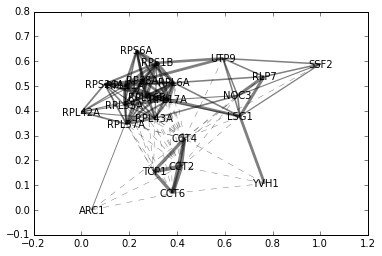

In [15]:
%run clust_intact 'Dosage Rescue' yeast

**2015 October 12-14**

Clean-up and re-organize *clust_intact.py* code. Soon after, it was found that genes without partners were still being shown for phenotypic suppression, and that repeated runs of dosage rescue led to different results. By pickling, it was confirmed that the output of *combine_sets()* was constant from run to run. Modifications were made instead to both *net_edges()* and *interaction_stats()* for the removal of set-pair intersections and genes without functional partners. 

Those modifications seemed to have worked as repeated runs show identical results and all genes in the networks have functional partners. The numbers as recorded on 10 October change for yeast as follows:

* Dosage Rescue: 24976 &rarr; 21528, 353 &rarr; 165
* Phenotypic Suppression: 46971 &rarr; 40755, 5868 &rarr; 3428
* Negative Genetic: 41905 &rarr; 38226, 40232 &rarr; 35636
* Phenotypic Enhancement: 71253 &rarr; 64620, 7449 &rarr; 3712
* Synthetic Lethality: 43365 &rarr; 56953, 16483 &rarr; 12380
* Synthetic Growth Defect: 231540 &rarr; 152076, 161529 &rarr; 75404
* Positive Genetic: 11325 &rarr; 13041, 5547 &rarr; 4113
* Synthetic Rescue: 37950 &rarr; 42778, 5649 &rarr; 4656
* Dosage Lethality: 861 &rarr; 703, 117 &rarr; 15
* Dosage Growth Defect: 13530 &rarr; 6105, 2341 &rarr; 546

and for human:

* Phenotypic Enhancement: 32 &rarr; 18
* Phenotypic Suppression: 595 &rarr; 561, 15 &rarr; 10

Plan to add *D. melanogaster* to analysis; update *clust_intact.py* accordingly. 

*clust_intact.py* was run on yeast, human and fly, and the Google Sheet *Genetic Interaction between Clusters* was filled out. 

**2015 October 15-16**

The sheer number of significant cluster pairs for negative genetic and synthetic growth defect casts doubt on their validity. By examining the most significant negative genetic cluster pairs, it does not seem that the bulk of the significance is accounted for by only a small group of genes; there seems to be enough variety among the gene groups. The background probabiity used for the binomial model is on about the same order for negative genetic as it is for other interaction types where a reasonable significant number was found. But according to the list of predictive seed sets (i.e. *Yeast_NegativeGenetic_seed_sets.txt*), the negative genetic and synthetic growth defect types have sets that contain a large number of gene interactors at AUCs closer to 0.9, especially compared to other interaction types. There are probably many interactions between these large interactor sets, thus causing most of the pairs to be statistically significant.  

The choice of background probability doesn't seem to be outrageous; in fact, it may even be a bit conservative. There are 2 possible alternatives to measuring significance of cluster interactions:

1. Create a genetic interaction network from the predictive seed set (e.g. seeds with AUC &ge; 0.9). For each cluster pair, randomly draw 2 pairs of sets that are equal in size to the actual cluster pair and compute the number of interactions between these 2 random set pairs. Repeat a number of times, and take the p-value to be the fraction of counts from random that are at least as great as the actual number. 

2. Create a number of random networks with identical degree sequence to the genetic interaction network described in 1.) above. Count the number of interactions between the cluster pair in each of the random networks; the resulting distribution of counts serves as the empirical distribution under the null. 

Method 1.) described above was implemented with the number of randomizations set to 100 iterations and Benjamini-Hochberg being used for multiple hypothesis correction. No statistical significance at 10% FDR was found for either dosage rescue or negative genetic, but the distribution of p-values looked reasonable, with a small number of results near the minimum p-value and most of the remaining ones near 1.0. The execution time for 100 iterations was about 10 minutes for dosage resuce (7875 pairs at minimum AUC = 0.9). It seems not so surprising from the calculation of the Benjamini-Hochberg correction that with such a small number of iterations no significance was found. 

The plotting of networks was also modified with the addition of the function *plot_1_network()* that plots each network of cluster pairs separately one-by-one for a given p-value cutoff. Furthermore, each cluster is plotted separately from the other with the genetic interaction edges overlaid at the end. The networks look reasonable. 

**2015 October 19**

The number of randomization iterations was bumped up to 1000 and the Bioconductor package 'qvalue' through rpy2 was used for multiple hypothesis correction. Unfortunately, no statistical significance was found at 10% for dosage rescue; 20% FDR would be needed to achieve significance. The output file is located at *tmp/qvalsDosageRescue-1e3iter.txt*. The number of randomization iterations is being increased to 10000 in the hopes of having the most significant p-values being small enough to achieve significance. Run started @ 15:53. 

**2015 October 20**

Job from yesterday finished @ 08:11, a runtime of 16 hr 18 min. 170 predictive seed sets that yielded 126 sets after Jaccard combination.  According to 'qvalue', at FDR 10% there were 39 significant cluster pair interactions (output file written to *tmp/qvalsDosageRescue-1e4iter.txt*). Benjamini-Hochberg also finds the same number:

In [4]:
fid = open('/work/jyoung/genetic_interact/tmp/qvalsDosageRescue-1e4iter.txt')
header = fid.readline()
pvals = [float(line.split()[0]) for line in fid]
fid.close()
rejected, pvalCorrect = fdrcorrection0(pvals, alpha=0.1)

In [5]:
np.sum(rejected)

39

Job for negative genetic started @ 14:43 and finished @ 15:59 (runtime = 1 hr 13 min). Minimum AUC = 0.9 yielding 595 pairs. 58 predictive seed sets yielding 35 sets after Jaccard combination. 'qvalue' found 5 statistically significant pairs at FDR 10%. 

**2015 October 21**

Created *clust_intact_parallel.py*, a slightly modified version of *clust_intact.py* and attempted to use the *joblib* library to parallelize the permutation test. The iteration over the cluster pairs was turned into a closure; however, this ultimately prevented the use of *joblib*, as "it is not possible to run parallel computing on function defined in closures as they cannot be pickled."

**2015 October 22**

The permutation test as described above may not be statistically valid since it is likely excessively strict. An approach using random graphs may need to be used, although the node choice would need to be carefully considered. 

**2015 October 26-27, 29**

As many (~10000) random graphs may need to be generated, an efficient method must be used to store the adjacency matrices. An attempt will be made to use *scipy.sparse* and the *shelve* module for this purpose. 

To start, generate the adjacency matrices for each genetic interaction type to get an idea of the matrix sizes and sparsity that are being dealt with. This is done in a small script *intactadjmat.py*. Then 2 groups of matrices will be shelved, where one group converts the matrices to a sparse format and the other maintains the dense structure. Compare file sizes of each shelved group. 

In constructing the genetic interaction adjacency matrices, use only the predictive seeds sets that have AUC &geq; 0.8. 

In [73]:
intactDF = intactadjmat.from_predictive(predictiveSeeds, seed2interactors)

In [74]:
intactDF.shape

(419, 419)

In [75]:
intactDF.sum().sum()/intactDF.size

0.0092503460335723771

| Interaction Type        | # of Genes | Density |
|-------------------------|------------|---------|
| Dosage Rescue           |  688       | 0.355%  |
| Phenotypic Suppression  |  971       | 0.370%  |
| Negative Genetic        | 2374       | 0.628%  |
| Phenotypic Enhancement  | 1006       | 0.370%  |
| Synthetic Lethality     | 1030       | 0.476%  |
| Synthetic Growth Defect | 1928       | 0.337%  |
| Positive Genetic        |  900       | 0.498%  |
| Synthetic Rescue        |  914       | 0.441%  |
| Dosage Lethality        |  184       | 1.713%  |
| Dosage Growth Defect    |  419       | 0.925%  |

Next, two Python "shelf" objects were created in */work/scratch/*. One of them contained 3 random 1% dense 2400-by-2400 matrices saved in compressed sparse row format; its *.dat* file takes up 2.1MB on disk. The other contained the same matrices but saved without any compression in dense form; its *.dat* file takes up 132MB on disk. 

**2015 October 29**

Discussion from a meeting concluded that when clusters are determined by functional net LLS sums, it is difficult to determine which cluster interactions are statistically signficant. The reason is that a permutation test would not de-convolute both genetic interactions between clusters and the fact that each cluster also interacts with a single gene. Thus, much of the work (i.e combining clusters) over the past month is wasted. 

The way forward now is to examine cluster interactions where the clusters are either protein complexes or functional net clusters (not determined by genetic interaction). 